In [1]:
from itertools import combinations
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from mpl_toolkits.mplot3d import Axes3D

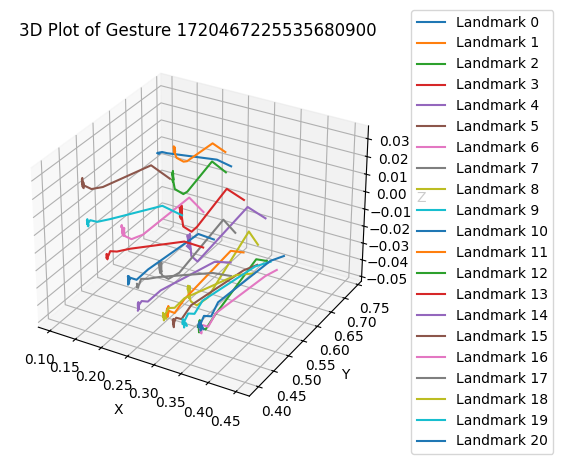

In [4]:
X_train_fe = pd.read_csv("./X_train_fe.csv")

gesture_id = 1720467225535680900
df_filtered = X_train_fe[X_train_fe['gesture_index'] == gesture_id]

num_landmarks = 21
x_coords = df_filtered[[f'x_{i}' for i in range(num_landmarks)]]
y_coords = df_filtered[[f'y_{i}' for i in range(num_landmarks)]]
z_coords = df_filtered[[f'z_{i}' for i in range(num_landmarks)]]

# Plot the coordinates
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each landmark point
for i in range(num_landmarks):
    ax.plot(x_coords[f'x_{i}'], y_coords[f'y_{i}'], z_coords[f'z_{i}'], label=f'Landmark {i}')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title(f'3D Plot of Gesture {gesture_id}')
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rectangle to make space for the legend
plt.show()

In [2]:
from itertools import combinations
import os
import sys
import time

from keras._tf_keras.keras.callbacks import EarlyStopping 
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout
from keras._tf_keras.keras.regularizers import l2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
from scipy.stats import skew, kurtosis
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [3]:

def create_dataframe_from_data(input_path: str):
    data_frames = []
    landmark_cols = []
    landmark_world_cols = [] 
    gesture_index = 0 

    for file_name in os.listdir(input_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_path, file_name)

            dataframe = pd.read_csv(file_path)

            # Gathers the landmark column names
            if(len(landmark_cols) == 0 and len(landmark_world_cols) == 0):
                landmark_cols = [col for col in dataframe.columns if col.startswith(("x", "y", "z"))]
                landmark_world_cols = [col for col in dataframe.columns if col.startswith(("wx", "wy", "wz"))]
            
            gesture = file_name.split("_")[0]
            gesture_index = int(file_name.split("_")[1].split(".")[0])

            dataframe["gesture"] = gesture
            dataframe["gesture_index"] = gesture_index

            dataframe.sort_values(by="frame", inplace=True)

            data_frames.append(dataframe)

    if len(data_frames) == 0:
        raise ValueError("Dataframe has no data")
    else:
        return pd.concat(data_frames, ignore_index=True), landmark_cols, landmark_world_cols

def split_dataset(dataframe: pd.DataFrame, label_col: str, train_ratio=0.6 , val_ratio=0.2, test_ratio=0.2):

    train_frames = []
    val_frames = []
    test_frames = []

    for _, gesture_data in dataframe.groupby("gesture_index"):
        n_frames = len(gesture_data)
        n_train = int(n_frames * train_ratio)
        n_val = int(n_frames * val_ratio)

        train_split = gesture_data.iloc[:n_train]
        val_split = gesture_data.iloc[n_train:n_train + n_val]
        test_split = gesture_data.iloc[n_train + n_val:]

        train_frames.append(train_split)
        val_frames.append(val_split)
        test_frames.append(test_split)
    
    train_set = pd.concat(train_frames).reset_index(drop=True)
    val_set = pd.concat(val_frames).reset_index(drop=True)
    test_set = pd.concat(test_frames).reset_index(drop=True)

    # Separate X and y
    X_train = train_set.drop(columns=[label_col])
    y_train = train_set[label_col]
    X_val = val_set.drop(columns=[label_col])
    y_val = val_set[label_col]
    X_test = test_set.drop(columns=[label_col])
    y_test = test_set[label_col]

    return X_train, y_train, X_val, y_val, X_test, y_test

def calculate_elapsed_time(df: pd.DataFrame):

    elapsed_lists = []

    for _, gesture_data in df.groupby("gesture_index"):
        avg_frame_rate = np.mean(gesture_data["frame_rate"])

        for i in gesture_data["frame"]:
            elapsed_lists.append(i / avg_frame_rate)
        
    df['elapsed_time'] = elapsed_lists

    return df

def calculate_temporal_features(df: pd.DataFrame, cols: list):
    velocity_cols = [f"velocity_{col}" for col in cols]
    acceleration_cols = [f"acceleration_{col}" for col in cols]
    jerk_cols = [f"jerk_{col}" for col in cols]
    
    for _, gesture_data in df.groupby("gesture_index"): 
        gesture_data = gesture_data.sort_values(by="frame")

        avg_frame_rate = np.mean(gesture_data["frame_rate"])
        time_diffs = gesture_data["frame"].diff().fillna(1) / avg_frame_rate
        
        velocities = gesture_data[cols].diff().div(time_diffs, axis=0).fillna(0)
        accelerations = velocities.diff().div(time_diffs, axis=0).fillna(0)
        jerks = accelerations.diff().div(time_diffs, axis=0).fillna(0)

        df.loc[gesture_data.index, velocity_cols] = velocities.values
        df.loc[gesture_data.index, acceleration_cols] = accelerations.values
        df.loc[gesture_data.index, jerk_cols] = jerks.values

    return df
  
def calculate_temporal_stats(df: pd.DataFrame, cols: list):
    mean_cols = [f"mean_{col}" for col in cols]
    var_cols = [f"variance_{col}" for col in cols] 
    dev_cols = [f"deviation_{col}" for col in cols] 
    skew_cols = [f"skew_{col}" for col in cols] 
    kurt_cols = [f"kurt_{col}" for col in cols] 

    for _, gesture_data in df.groupby("gesture_index"):
        gesture_data = gesture_data.sort_values(by="frame")

        df.loc[gesture_data.index, dev_cols] = gesture_data[cols].rolling(2).std(engine="cython").values # might convert these to numpy for better efificeny in the future
        df.loc[gesture_data.index, var_cols] = gesture_data[cols].rolling(2).var(engine="cython").values
        df.loc[gesture_data.index, skew_cols] = gesture_data[cols].rolling(6).skew().values
        df.loc[gesture_data.index, kurt_cols] = gesture_data[cols].rolling(6).kurt().values
        df.loc[gesture_data.index, mean_cols] = gesture_data[cols].expanding().mean(engine="cython").values

    return df

def calculate_landmark_distances(df: pd.DataFrame, cols: list):
    distance_columns = [f"lm_distance_{i}_{j}" for i in range(len(cols)//3) for j in range(len(cols)//3)]

    for _, gesture_data in df.groupby("gesture_index"):
        gesture_data = gesture_data.sort_values(by="frame")
        
        coords = gesture_data[cols].values.reshape(-1, len(cols) // 3, 3)
        distances = np.sqrt(np.sum((coords[:, :, None] - coords[:, None, :])**2, axis=-1))
        
        # we technically should do something called zero out - basically in the df x_0/x_1 == x_1/x_0 (redundant)

        distances_flat = distances.reshape(-1, len(distance_columns))
        df.loc[gesture_data.index, distance_columns] = distances_flat

    return df

def calculate_landmark_angles(df: pd.DataFrame, cols: list):
    angles_per_gesture_list = []
    for _, gesture_data in df.groupby("gesture_index"):
        gesture_data = gesture_data.sort_values(by="frame")
        gesture_points = gesture_data[cols]
        angles_for_gesture = []

        
        # Iterate over each pair of consecutive points
        for i in range(len(gesture_points) - 1):
            point_a = gesture_points.iloc[i]
            point_b = gesture_points.iloc[i + 1]

            angles = []
            
            # Iterate over each landmark
            for j in range(21):
                idx = j  # Adjust if cols include additional information beyond x, y, z (e.g., wx, wy, wz)
                
                # Extract coordinates for point_a and point_b
                ax, ay, az = point_a[f"x_{idx}"], point_a[f"y_{idx}"], point_a[f"z_{idx}"]
                bx, by, bz = point_b[f"x_{idx}"], point_b[f"y_{idx}"], point_b[f"z_{idx}"]

                # Calculate dot product
                dot_prod = ax * bx + ay * by + az * bz

                # Calculate magnitudes
                magnitude1 = np.linalg.norm([ax, ay, az])
                magnitude2 = np.linalg.norm([bx, by, bz])

                # Calculate angle in degrees
                if magnitude1 > 0 and magnitude2 > 0:
                    angle = np.arccos(np.clip(dot_prod / (magnitude1 * magnitude2), -1.0, 1.0)) * (180 / np.pi)
                else:
                    angle = 0.0  # Handle division by zero or near-zero magnitude cases

                angles.append(angle)

            angles_for_gesture.append(angles)

        angles_per_gesture_list.extend(angles_for_gesture) 

    # Create DataFrame with angles_per_gesture_list
    angles_cols = [f"angle_{n1}" for n1 in range(21)]
    angles_per_gesture_list.insert(0, [0.0] * len(angles_cols))
    angles_df = pd.DataFrame(angles_per_gesture_list, columns=angles_cols)
    # Append angles_df to df
    df = pd.concat([df, angles_df], axis=1)

    return df

def calculate_hand_motion_features(df: pd.DataFrame, landmark_cols: list):
    """
    List of features
        Elasped time - time of the the recorded gesture since frame 0 ✅
        velocity ✅
        acceleration ✅
        jerk ✅
        pairwise distances ✅
        landmark angles ✅
        gesture_stats - mean, variance, skewness, and kurtosis ✅

        process time
            elapsed_time_fuc - 0.15625
            temporal - 6.671875
            stats - 24.1875
            landmarks - 85.421875 -> 32.203125 (more like 60 if running all functions)
            angles - 4.265625

        problems to hand - skew, kurt, and variance have null values - because of the lack of fillna. Skew and kurt are bigger problems cuz of rolling (will use interpolation for this and others)
        distance is just not being calculated  ✅
    """
    df_copy = df.copy()

    s = time.process_time()
    df_elapsed = calculate_elapsed_time(df_copy)    
    print(time.process_time()-s)


    s = time.process_time()
    df_temporal = calculate_temporal_features(df_copy, landmark_cols)
    print(time.process_time()-s)
    
    s = time.process_time()
    df_stats = calculate_temporal_stats(df_copy, landmark_cols)
    print(time.process_time()-s)


    s = time.process_time()
    df_pairwise = calculate_landmark_distances(df_copy, landmark_cols)
    print(time.process_time()-s)


    s = time.process_time()
    df_angle = calculate_landmark_angles(df_copy, landmark_cols)
    print(time.process_time()-s)
   
    
    s = time.process_time()
    df_combined = pd.concat([df_copy, df_angle], axis=1)
    print(time.process_time()-s)
    
    # Ensure there are no duplicate columns
    df_combined = df_combined.loc[:,~df_combined.columns.duplicated()]
   
    return df_combined

def display_null_columns(df: pd.DataFrame):
    null_counts = df.isnull().sum()
    null_columns = null_counts[null_counts > 0]
    
    result_df = pd.DataFrame({'Column': null_columns.index, 'Null Count': null_columns.values})
    return result_df

imported
(6372, 1100)||(2087, 1100)||(2246, 1100)
done
(6372, 1236)||(2087, 1236)||(2246, 1236)
(6372,)||(2087,)||(2246,)
Selected features (Lasso): [ 124  466  478  714  735 1073 1079 1235]
(6372, 8)||(2087, 8)||(2246, 8)
(6372,)||(2087,)||(2246,)
Epoch 1/10


c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3204 - loss: 1.7116 - val_accuracy: 0.6363 - val_loss: 1.1484
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6920 - loss: 1.0183 - val_accuracy: 0.6818 - val_loss: 0.8653
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7516 - loss: 0.7531 - val_accuracy: 0.7000 - val_loss: 0.7166
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7891 - loss: 0.6604 - val_accuracy: 0.7250 - val_loss: 0.6853
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8026 - loss: 0.6167 - val_accuracy: 0.7738 - val_loss: 0.6111
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8119 - loss: 0.5825 - val_accuracy: 0.8256 - val_loss: 0.5505
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8227 - loss: 0.5490 - val_accuracy: 0.7820 - val_loss: 0.6523
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8216 - loss: 0.5367 - val_accuracy: 0.7738 - val_

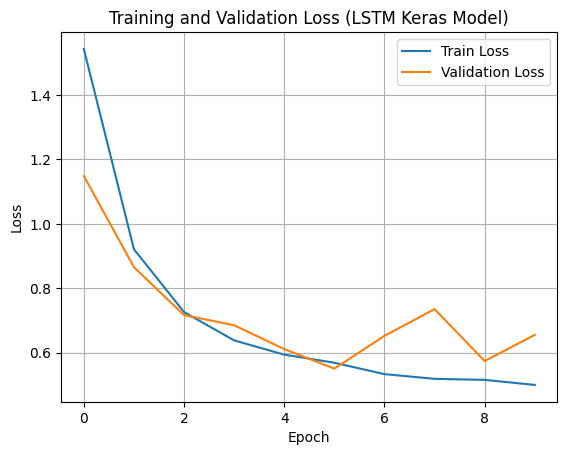

In [10]:
def main():
    input_dir = "C:\\Users\\Gen3r\\Documents\\capstone\\ml_model\\data\\data_2"

    # Step 1: Get data into frame
    dataframe, landmark_cols, landmark_world_cols = create_dataframe_from_data(input_dir)

    # Step 2: Split data into train test val sets
    X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(dataframe, "gesture")

    # Step 3: Feature Engineer
    isActive = True
    if os.path.exists("X_test_fe.csv") and isActive == True:
        X_train_fe = pd.read_csv("X_train_fe.csv")
        X_val_fe = pd.read_csv("X_val_fe.csv")
        X_test_fe = pd.read_csv("X_test_fe.csv")
        print("imported")
    else:
        print(False)
        X_train_fe = calculate_hand_motion_features(X_train, landmark_cols)
        X_val_fe = calculate_hand_motion_features(X_val, landmark_cols)
        X_test_fe = calculate_hand_motion_features(X_test, landmark_cols)

        X_train_fe.to_csv("model/LSTM/v2/X_train_fe.csv", index=False)
        X_val_fe.to_csv("model/LSTM/v2/X_val_fe.csv", index=False)
        X_test_fe.to_csv("model/LSTM/v2/X_test_fe.csv", index=False)

    # Preprocessing 
    # need to have numeric, cat, and ordinal cols
    timeseries_columns = (
        landmark_cols + landmark_world_cols + ['elapsed_time'] + [f"velocity_{col}" for col in landmark_cols] + [f"acceleration_{col}" for col in landmark_cols] 
        + [f"jerk_{col}" for col in landmark_cols]+ [f"mean_{col}" for col in landmark_cols] + [f"variance_{col}" for col in landmark_cols] 
        + [f"deviation_{col}" for col in landmark_cols] + [f"skew_{col}" for col in landmark_cols] + [f"kurt_{col}" for col in landmark_cols] 
        + [f"lm_distance_{i}_{j}" for i in range(len(landmark_cols)//3) for j in range(len(landmark_cols)//3)] + [f"angle_{n1}" for n1 in range(21)] + ["score"]
    )
    print(f"{X_train_fe.shape}||{X_val_fe.shape}||{X_test_fe.shape}")

    numerical_columns = ["frame_rate","frame_width","frame_height","gesture_index"]
    categorical_columns = ['hand', 'gesture_index']
    
    ts_numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('imputer2', SimpleImputer(strategy="mean")),
        ('scaler', MinMaxScaler()),
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ("normalize", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('ts_num', ts_numerical_transformer, timeseries_columns),
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough',
        sparse_threshold=0,
        n_jobs=-1
    )
    # preprocessor.set_output(transform="pandas")
    
    X_train_transformed = preprocessor.fit_transform(X_train_fe)
    X_val_transformed = preprocessor.transform(X_val_fe)
    X_test_transformed = preprocessor.transform(X_test_fe)
    print("done")
    label_encoder = LabelEncoder()
    combined_labels = pd.concat([y_train, y_val, y_test])
    label_encoder.fit(combined_labels)

    y_train_encoded = label_encoder.transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
   
    print(f"{X_train_transformed.shape}||{X_val_transformed.shape}||{X_test_transformed.shape}")
    print(f"{y_train_encoded.shape}||{y_val_encoded.shape}||{y_test_encoded.shape}")

    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train_transformed, y_train_encoded)
    model_1 = SelectFromModel(lasso, prefit=True)

    X_train_transformed = model_1.transform(X_train_transformed)
    X_val_transformed = model_1.transform(X_val_transformed)
    X_test_transformed = model_1.transform(X_test_transformed)

    print("Selected features (Lasso):", model_1.get_support(indices=True))

    # Reshape the selected features for LSTM input
    X_train_reshaped = X_train_transformed.reshape((X_train_transformed.shape[0], X_train_transformed.shape[1], 1))
    X_val_reshaped = X_val_transformed.reshape((X_val_transformed.shape[0], X_val_transformed.shape[1], 1))
    X_test_reshaped = X_test_transformed.reshape((X_test_transformed.shape[0], X_test_transformed.shape[1], 1))

    print(f"{X_train_transformed.shape}||{X_val_transformed.shape}||{X_test_transformed.shape}")
    print(f"{y_train_encoded.shape}||{y_val_encoded.shape}||{y_test_encoded.shape}")

    # Define LSTM model
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(X_train_transformed.shape[1], 1), return_sequences=True, kernel_regularizer=l2()))
    model.add(Dropout(0.2))
    model.add(LSTM(units=8, return_sequences=False)),  # Optional additional LSTM layer
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))


    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train_reshaped, y_train_encoded, 
        epochs=10, 
        batch_size=32,
        validation_data=(X_val_reshaped, y_val_encoded), 
        callbacks=[early_stopping])

    # Evaluate the model on test set
    test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_encoded)
    print(f'Test Accuracy: {test_acc} || Test Loss: {test_loss}')

    # Extracting the history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    epochs = range(len(train_loss))  # Assuming loss recorded for each epoch

    # Plotting
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss (LSTM Keras Model)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

        

main()

imported
(6372, 1100)||(2087, 1100)||(2246, 1100)
done
(6372, 1236)||(2087, 1236)||(2246, 1236)
(6372,) || (2087,) || (2246,)
Selected features (Lasso): [ 124  466  478  714  735 1073 1079 1235]
(6372, 8)||(2087, 8)||(2246, 8)
(6372,) || (2087,) || (2246,)
Epoch 1/50


c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4506 - loss: 1.6812 - val_accuracy: 0.0000e+00 - val_loss: 2.9248 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5413 - loss: 1.0118 - val_accuracy: 0.0000e+00 - val_loss: 3.2739 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5330 - loss: 0.9497 - val_accuracy: 0.0000e+00 - val_loss: 3.5456 - learning_rate: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5700 - loss: 0.8795 - val_accuracy: 0.0000e+00 - val_loss: 3.8282 - learning_rate: 0.0010
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5583 - loss: 0.8597 - val_accuracy: 0.0000e+00 - val_loss: 4.0420 - learning_rate: 0.0010
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5153 - loss: 0.8577 - val_accuracy: 0.0000e+00 - val_loss: 4.2097 - learning_rate: 0.0010
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 3.6194
Validatio

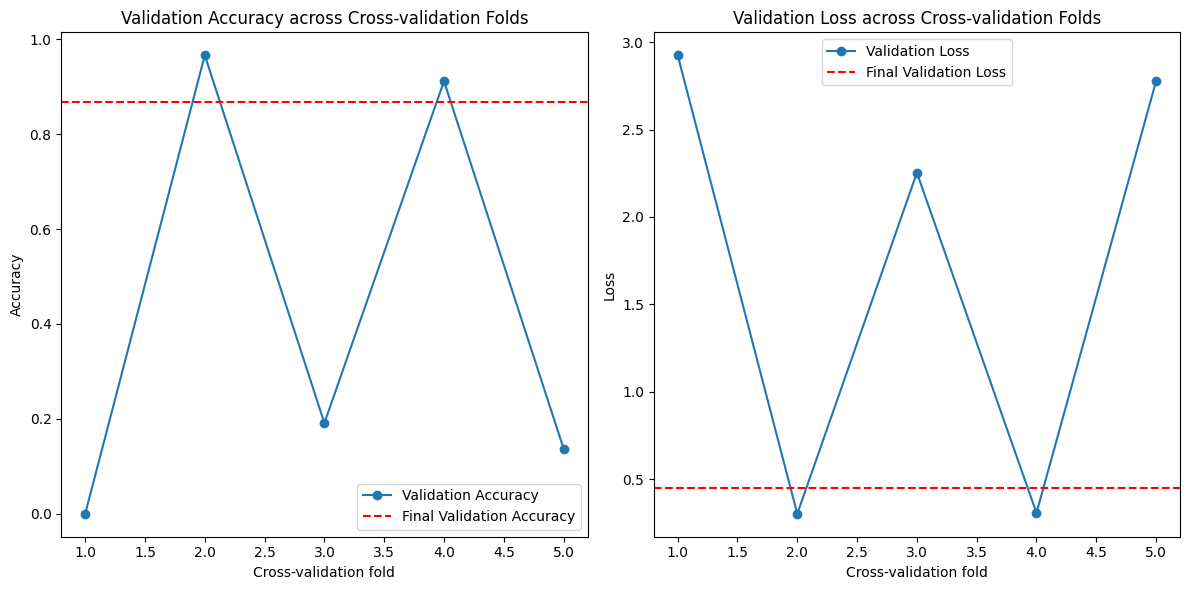

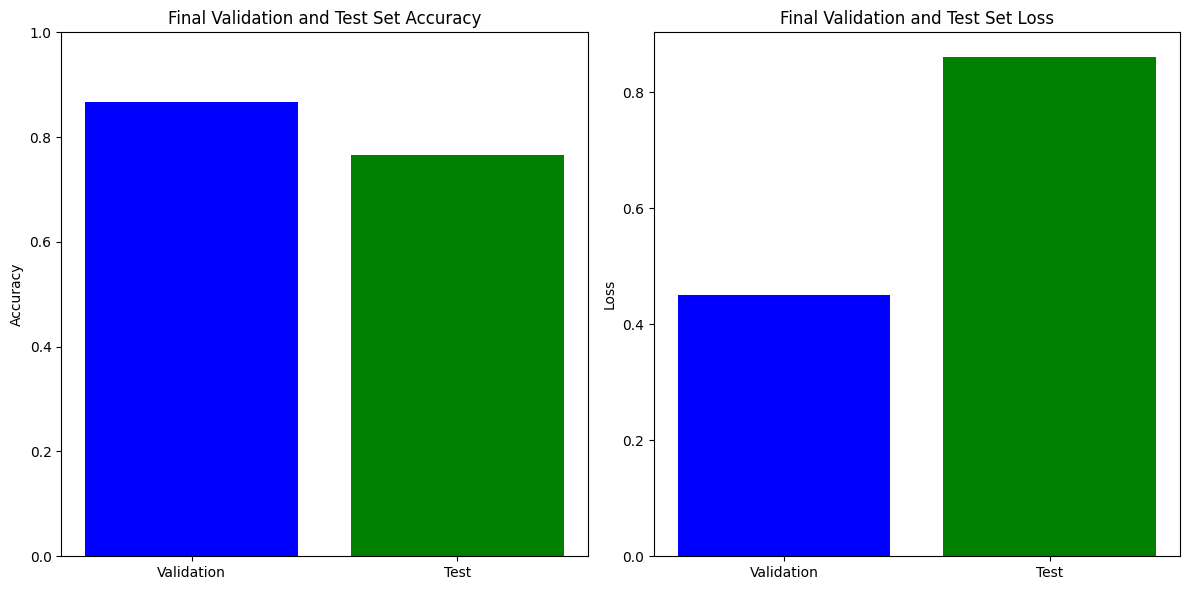

In [5]:
# Version 2 of LSTM model, will be more precise than before
from itertools import combinations
import os
import sys
import time
from typing import Optional

from imblearn.over_sampling import SMOTE
from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras._tf_keras.keras.metrics import MeanAbsoluteError, Accuracy
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout
from keras._tf_keras.keras.regularizers import l2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
from scipy.stats import skew, kurtosis
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

def create_dataframe_from_data(input_path: str):
    data_frames = []
    landmark_cols = []
    landmark_world_cols = [] 
    gesture_index = 0 

    for file_name in os.listdir(input_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_path, file_name)

            dataframe = pd.read_csv(file_path)

            # Gathers the landmark column names
            if(len(landmark_cols) == 0 and len(landmark_world_cols) == 0):
                landmark_cols = [col for col in dataframe.columns if col.startswith(("x", "y", "z"))]
                landmark_world_cols = [col for col in dataframe.columns if col.startswith(("wx", "wy", "wz"))]
            
            gesture = file_name.split("_")[0]
            gesture_index = int(file_name.split("_")[1].split(".")[0])

            dataframe["gesture"] = gesture
            dataframe["gesture_index"] = gesture_index

            dataframe.sort_values(by="frame", inplace=True)

            data_frames.append(dataframe)

    if len(data_frames) == 0:
        raise ValueError("Dataframe has no data")
    else:
        return pd.concat(data_frames, ignore_index=True), landmark_cols, landmark_world_cols

def split_dataset(dataframe: pd.DataFrame, label_col: str, train_ratio=0.6 , val_ratio=0.2, test_ratio=0.2):

    train_frames = []
    val_frames = []
    test_frames = []

    for _, gesture_data in dataframe.groupby("gesture_index"):
        n_frames = len(gesture_data)
        n_train = int(n_frames * train_ratio)
        n_val = int(n_frames * val_ratio)

        train_split = gesture_data.iloc[:n_train]
        val_split = gesture_data.iloc[n_train:n_train + n_val]
        test_split = gesture_data.iloc[n_train + n_val:]

        train_frames.append(train_split)
        val_frames.append(val_split)
        test_frames.append(test_split)
    
    train_set = pd.concat(train_frames).reset_index(drop=True)
    val_set = pd.concat(val_frames).reset_index(drop=True)
    test_set = pd.concat(test_frames).reset_index(drop=True)

    # Separate X and y
    X_train = train_set.drop(columns=[label_col])
    y_train = train_set[label_col]
    X_val = val_set.drop(columns=[label_col])
    y_val = val_set[label_col]
    X_test = test_set.drop(columns=[label_col])
    y_test = test_set[label_col]

    return X_train, y_train, X_val, y_val, X_test, y_test

def calculate_elapsed_time(df: pd.DataFrame):

    elapsed_lists = []

    for _, gesture_data in df.groupby("gesture_index"):
        avg_frame_rate = np.mean(gesture_data["frame_rate"])

        for i in gesture_data["frame"]:
            elapsed_lists.append(i / avg_frame_rate)
        
    df['elapsed_time'] = elapsed_lists

    return df

def calculate_temporal_features(df: pd.DataFrame, cols: list):
    velocity_cols = [f"velocity_{col}" for col in cols]
    acceleration_cols = [f"acceleration_{col}" for col in cols]
    jerk_cols = [f"jerk_{col}" for col in cols]
    
    for _, gesture_data in df.groupby("gesture_index"): 
        gesture_data = gesture_data.sort_values(by="frame")

        avg_frame_rate = np.mean(gesture_data["frame_rate"])
        time_diffs = gesture_data["frame"].diff().fillna(1) / avg_frame_rate
        
        velocities = gesture_data[cols].diff().div(time_diffs, axis=0).fillna(0)
        accelerations = velocities.diff().div(time_diffs, axis=0).fillna(0)
        jerks = accelerations.diff().div(time_diffs, axis=0).fillna(0)

        df.loc[gesture_data.index, velocity_cols] = velocities.values
        df.loc[gesture_data.index, acceleration_cols] = accelerations.values
        df.loc[gesture_data.index, jerk_cols] = jerks.values

    return df
  
def calculate_temporal_stats(df: pd.DataFrame, cols: list):
    mean_cols = [f"mean_{col}" for col in cols]
    var_cols = [f"variance_{col}" for col in cols] 
    dev_cols = [f"deviation_{col}" for col in cols] 
    skew_cols = [f"skew_{col}" for col in cols] 
    kurt_cols = [f"kurt_{col}" for col in cols] 

    for _, gesture_data in df.groupby("gesture_index"):
        gesture_data = gesture_data.sort_values(by="frame")

        df.loc[gesture_data.index, dev_cols] = gesture_data[cols].rolling(2).std(engine="cython").values # might convert these to numpy for better efificeny in the future
        df.loc[gesture_data.index, var_cols] = gesture_data[cols].rolling(2).var(engine="cython").values
        df.loc[gesture_data.index, skew_cols] = gesture_data[cols].rolling(6).skew().values
        df.loc[gesture_data.index, kurt_cols] = gesture_data[cols].rolling(6).kurt().values
        df.loc[gesture_data.index, mean_cols] = gesture_data[cols].expanding().mean(engine="cython").values

    return df

def calculate_landmark_distances(df: pd.DataFrame, cols: list):
    distance_columns = [f"lm_distance_{i}_{j}" for i in range(len(cols)//3) for j in range(len(cols)//3)]

    for _, gesture_data in df.groupby("gesture_index"):
        gesture_data = gesture_data.sort_values(by="frame")
        
        coords = gesture_data[cols].values.reshape(-1, len(cols) // 3, 3)
        distances = np.sqrt(np.sum((coords[:, :, None] - coords[:, None, :])**2, axis=-1))
        
        # we technically should do something called zero out - basically in the df x_0/x_1 == x_1/x_0 (redundant)

        distances_flat = distances.reshape(-1, len(distance_columns))
        df.loc[gesture_data.index, distance_columns] = distances_flat

    return df

def calculate_landmark_angles(df: pd.DataFrame, cols: list):
    angles_per_gesture_list = []
    for _, gesture_data in df.groupby("gesture_index"):
        gesture_data = gesture_data.sort_values(by="frame")
        gesture_points = gesture_data[cols]
        angles_for_gesture = []

        
        # Iterate over each pair of consecutive points
        for i in range(len(gesture_points) - 1):
            point_a = gesture_points.iloc[i]
            point_b = gesture_points.iloc[i + 1]

            angles = []
            
            # Iterate over each landmark
            for j in range(21):
                idx = j  # Adjust if cols include additional information beyond x, y, z (e.g., wx, wy, wz)
                
                # Extract coordinates for point_a and point_b
                ax, ay, az = point_a[f"x_{idx}"], point_a[f"y_{idx}"], point_a[f"z_{idx}"]
                bx, by, bz = point_b[f"x_{idx}"], point_b[f"y_{idx}"], point_b[f"z_{idx}"]

                # Calculate dot product
                dot_prod = ax * bx + ay * by + az * bz

                # Calculate magnitudes
                magnitude1 = np.linalg.norm([ax, ay, az])
                magnitude2 = np.linalg.norm([bx, by, bz])

                # Calculate angle in degrees
                if magnitude1 > 0 and magnitude2 > 0:
                    angle = np.arccos(np.clip(dot_prod / (magnitude1 * magnitude2), -1.0, 1.0)) * (180 / np.pi)
                else:
                    angle = 0.0  # Handle division by zero or near-zero magnitude cases

                angles.append(angle)

            angles_for_gesture.append(angles)

        angles_per_gesture_list.extend(angles_for_gesture) 

    # Create DataFrame with angles_per_gesture_list
    angles_cols = [f"angle_{n1}" for n1 in range(21)]
    angles_per_gesture_list.insert(0, [0.0] * len(angles_cols))
    angles_df = pd.DataFrame(angles_per_gesture_list, columns=angles_cols)
    # Append angles_df to df
    df = pd.concat([df, angles_df], axis=1)

    return df

def calculate_hand_motion_features(df: pd.DataFrame, landmark_cols: list):
    """
    List of features
        Elasped time - time of the the recorded gesture since frame 0 ✅
        velocity ✅
        acceleration ✅
        jerk ✅
        pairwise distances ✅
        landmark angles ✅
        gesture_stats - mean, variance, skewness, and kurtosis ✅

        process time
            elapsed_time_fuc - 0.15625
            temporal - 6.671875
            stats - 24.1875
            landmarks - 85.421875 -> 32.203125 (more like 60 if running all functions)
            angles - 4.265625

        problems to hand - skew, kurt, and variance have null values - because of the lack of fillna. Skew and kurt are bigger problems cuz of rolling (will use interpolation for this and others)
        distance is just not being calculated  ✅
    """
    df_copy = df.copy()

    s = time.process_time()
    df_elapsed = calculate_elapsed_time(df_copy)    
    print(time.process_time()-s)


    s = time.process_time()
    df_temporal = calculate_temporal_features(df_copy, landmark_cols)
    print(time.process_time()-s)
    
    s = time.process_time()
    df_stats = calculate_temporal_stats(df_copy, landmark_cols)
    print(time.process_time()-s)


    s = time.process_time()
    df_pairwise = calculate_landmark_distances(df_copy, landmark_cols)
    print(time.process_time()-s)


    s = time.process_time()
    df_angle = calculate_landmark_angles(df_copy, landmark_cols)
    print(time.process_time()-s)
   
    
    s = time.process_time()
    df_combined = pd.concat([df_copy, df_angle], axis=1)
    print(time.process_time()-s)
    
    # Ensure there are no duplicate columns
    df_combined = df_combined.loc[:,~df_combined.columns.duplicated()]
   
    return df_combined

def display_null_columns(df: pd.DataFrame):
    null_counts = df.isnull().sum()
    null_columns = null_counts[null_counts > 0]
    
    result_df = pd.DataFrame({'Column': null_columns.index, 'Null Count': null_columns.values})
    return result_df

def reshape_for_lstm(X, num_timesteps):
    num_samples = X.shape[0]
    return X.reshape(num_samples, num_timesteps, -1) # Reshape the data to (num_samples, num_timesteps, num_features)

def main():
    input_dir = "C:\\Users\\Gen3r\\Documents\\capstone\\ml_model\\data\\data_2"

    # Step 1: Get data into frame
    dataframe, landmark_cols, landmark_world_cols = create_dataframe_from_data(input_dir)

    # Step 2: Split data into train test val sets
    X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(dataframe, "gesture")

    # Step 3: Feature Engineer
    isActive = True
    if os.path.exists("X_train_fe.csv") and isActive == True:
        X_train_fe = pd.read_csv("X_train_fe.csv")
        X_val_fe = pd.read_csv("X_val_fe.csv")
        X_test_fe = pd.read_csv("X_test_fe.csv")
        print("imported")
    else:
        X_train_fe = calculate_hand_motion_features(X_train, landmark_cols)
        X_val_fe = calculate_hand_motion_features(X_val, landmark_cols)
        X_test_fe = calculate_hand_motion_features(X_test, landmark_cols)

        X_train_fe.to_csv("model/LSTM/v2/X_train_fe.csv", index=False)
        X_val_fe.to_csv("model/LSTM/v2/X_val_fe.csv", index=False)
        X_test_fe.to_csv("model/LSTM/v2/X_test_fe.csv", index=False)

    print_shapes(X_train_fe, X_val_fe, X_test_fe)
    
    # Step 4: Preprocessing 
    numerical_columns = ["frame_rate","frame_width","frame_height","gesture_index"]
    categorical_columns = ['hand', 'gesture_index']
    
    derived_features = ['elapsed_time'] + \
                [f"{feat}_{col}" for feat in ["velocity", "acceleration", "jerk", "mean", "variance", "deviation", "skew", "kurt"] for col in landmark_cols] + \
                [f"lm_distance_{i}_{j}" for i in range(len(landmark_cols)//3) for j in range(len(landmark_cols)//3)] + \
                [f"angle_{n1}" for n1 in range(21)] + \
                ["score"]
    timeseries_columns = landmark_cols + landmark_world_cols + derived_features

    preprocessor = preprocess_pipeline(timeseries_columns, numerical_columns, categorical_columns)
    
    X_train_transformed = preprocessor.fit_transform(X_train_fe)
    X_val_transformed = preprocessor.transform(X_val_fe)
    X_test_transformed = preprocessor.transform(X_test_fe)
    print("done")

    label_encoder = LabelEncoder()
    combined_labels = pd.concat([y_train, y_val, y_test])
    label_encoder.fit(combined_labels)

    y_train_encoded = label_encoder.transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
   
    print_shapes(X_train_transformed, X_val_transformed, X_test_transformed, y_train_encoded, y_val_encoded, y_test_encoded)

    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train_transformed, y_train_encoded)
    model_1 = SelectFromModel(lasso, prefit=True)

    X_train_transformed = model_1.transform(X_train_transformed)
    X_val_transformed = model_1.transform(X_val_transformed)
    X_test_transformed = model_1.transform(X_test_transformed)

    print("Selected features (Lasso):", model_1.get_support(indices=True))

    # Reshape the selected features for LSTM input
    X_train_reshaped = reshape_for_lstm(X_train_transformed, X_train_transformed.shape[1])
    X_val_reshaped = reshape_for_lstm(X_val_transformed, X_val_transformed.shape[1])
    X_test_reshaped = reshape_for_lstm(X_test_transformed, X_test_transformed.shape[1])

    print_shapes(X_train_transformed, X_val_transformed, X_test_transformed, y_train_encoded, y_val_encoded, y_test_encoded)

    n_splits = 5 
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_accuracies = []
    cv_losses = []
    for train_index, val_index in tscv.split(X_train_transformed):
        X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
        y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

        # Reshape for LSTM
        X_train_fold_reshaped = reshape_for_lstm(X_train_fold, X_train_fold.shape[1])
        X_val_fold_reshaped = reshape_for_lstm(X_val_fold, X_val_fold.shape[1])

        # Define and train the LSTM model
        model = create_lstm(X_train_fold.shape[1], len(label_encoder.classes_))

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

        history = model.fit(
            X_train_fold_reshaped, y_train_fold,
            epochs=50,
            batch_size=32,
            validation_data=(X_val_fold_reshaped, y_val_fold),
            callbacks=[early_stopping, reduce_lr]
        )

        val_loss, val_acc = model.evaluate(X_val_fold_reshaped, y_val_fold)
        cv_losses.append(val_loss)
        cv_accuracies.append(val_acc)
        print(f'Validation Accuracy: {val_acc} || Validation Loss: {val_loss}')

    # Print average accuracy and loss over all cross-validation folds
    avg_cv_acc = np.mean(cv_accuracies)
    avg_cv_loss = np.mean(cv_losses)
    print(f'Average CV Accuracy: {avg_cv_acc} || Average CV Loss: {avg_cv_loss}')

    # Train the final model on the entire training set
    final_model = create_lstm(X_train_transformed.shape[1], len(label_encoder.classes_))
    history = final_model.fit(
        X_train_reshaped, y_train_encoded,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_reshaped, y_val_encoded),
        callbacks=[early_stopping, reduce_lr]
    )

    # Final evaluation on validation and test sets
    val_loss, val_acc = final_model.evaluate(X_val_reshaped, y_val_encoded)
    print(f'Validation Set Accuracy: {val_acc} || Validation Set Loss: {val_loss}')

    test_loss, test_acc = final_model.evaluate(X_test_reshaped, y_test_encoded)
    print(f'Test Accuracy: {test_acc} || Test Loss: {test_loss}')


    # Assuming you have collected the following metrics during your training
    # cv_accuracies, cv_losses for cross-validation folds
    # val_acc, val_loss for validation set after training final model
    # test_acc, test_loss for test set evaluation

    # Plotting validation accuracies
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cv_accuracies) + 1), cv_accuracies, marker='o', label='Validation Accuracy')
    plt.axhline(y=val_acc, color='r', linestyle='--', label='Final Validation Accuracy')
    plt.xlabel('Cross-validation fold')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy across Cross-validation Folds')
    plt.legend()

    # Plotting validation losses
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cv_losses) + 1), cv_losses, marker='o', label='Validation Loss')
    plt.axhline(y=val_loss, color='r', linestyle='--', label='Final Validation Loss')
    plt.xlabel('Cross-validation fold')
    plt.ylabel('Loss')
    plt.title('Validation Loss across Cross-validation Folds')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotting final validation and test set accuracies and losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(['Validation', 'Test'], [val_acc, test_acc], color=['b', 'g'])
    plt.ylabel('Accuracy')
    plt.title('Final Validation and Test Set Accuracy')
    plt.ylim(0, 1)

    plt.subplot(1, 2, 2)
    plt.bar(['Validation', 'Test'], [val_loss, test_loss], color=['b', 'g'])
    plt.ylabel('Loss')
    plt.title('Final Validation and Test Set Loss')

    plt.tight_layout()
    plt.show()


def create_lstm(input_shape, output_units):
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(input_shape, 1), return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=8, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=output_units, activation="softmax"))
    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def preprocess_pipeline(timeseries_columns, numerical_columns, categorical_columns):
    ts_numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)), # might want to change this out back to the interpolatioon methods
        ('imputer2', SimpleImputer(strategy="mean")),
        ('scaler', MinMaxScaler())
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ("normalize", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")), # technically this is wrong
        ("ohe", OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('ts_num', ts_numerical_transformer, timeseries_columns),
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough',
        sparse_threshold=0,
        n_jobs=-1
    )
    
    return preprocessor

def print_shapes(X_train, X_val, X_test, y_train = None, y_val = None, y_test = None):
    print(f"{X_train.shape}||{X_val.shape}||{X_test.shape}")
    if y_train is not None and y_val is not None and y_test is not None:
        print(f"{y_train.shape} || {y_val.shape} || {y_test.shape}")


        

main()